# Assignment 3 - Mining Data Streams

Changhe You and Zekai Lin

# Core Algorithm - TRIES-IMPR

In [1]:
import random
from collections import defaultdict

class TriestImpr:
    """
    Implementation of TRIÈST-IMPR algorithm for streaming triangle counting.
    Paper: TRIÈST: Counting Local and Global Triangles in Fully-Dynamic Streams with Fixed Memory Size
    """

    def __init__(self, memory_size: int):
        """
        Initialize the TRIEST-IMPR counter.
        
        :param memory_size: M, the maximum number of edges to store in the reservoir.
        """
        self.M = memory_size
        self.t = 0  # Current time step (number of edges processed)
        self.global_triangle_count = 0.0
        
        # Reservoir storage
        # 1. Adjacency list for fast neighbor lookup: Node -> Set of Neighbors
        self.sample_graph = defaultdict(set)
        # 2. List of edges for random access/deletion: List[(u, v)]
        self.sample_edges = [] 

    def update(self, edge):
        """
        Process a single edge from the stream.
        
        :param edge: A tuple (u, v) representing an edge.
        """
        u, v = edge
        if u == v: return  # Ignore self-loops
        
        self.t += 1
        
        # --- Step 1: Update Counters (TRIÈST-IMPR Core) ---
        # Use the current sample to estimate triangles BEFORE making sampling decisions.
        self._update_counters(u, v)

        # --- Step 2: Reservoir Sampling (Lecture 4 Core) ---
        self._maintain_reservoir(u, v)

    def _update_counters(self, u, v):
        """
        Calculates the weight and updates the global triangle count.
        """
        # Optimization: If one node is not in sample, they have no common neighbors in sample.
        if u not in self.sample_graph or v not in self.sample_graph:
            return

        # Find common neighbors in the sample S
        common_neighbors = self.sample_graph[u].intersection(self.sample_graph[v])
        
        if not common_neighbors:
            return

        # Calculate weight eta_t based on the formula in Paper B
        eta = self._get_weight()
        
        # Update global count
        weighted_increase = eta * len(common_neighbors)
        self.global_triangle_count += weighted_increase

    def _get_weight(self):
        """
        Computes the weight coefficient eta_t.
        If t <= M, weight is 1.0.
        If t > M, weight is ((t-1)(t-2)) / (M(M-1)).
        """
        if self.t <= self.M:
            return 1.0
        else:
            # Explicit float conversion for safety
            numerator = (self.t - 1) * (self.t - 2)
            denominator = self.M * (self.M - 1)
            return float(numerator) / float(denominator)

    def _maintain_reservoir(self, u, v):
        """
        Standard Reservoir Sampling logic.
        """
        if self.t <= self.M:
            # Reservoir not full: always add
            self._add_edge_to_sample(u, v)
        else:
            # Reservoir full: probabilistic update
            if random.random() < (self.M / self.t):
                # Remove a random old edge
                self._remove_random_edge()
                # Add the new edge
                self._add_edge_to_sample(u, v)

    def _add_edge_to_sample(self, u, v):
        self.sample_graph[u].add(v)
        self.sample_graph[v].add(u)
        self.sample_edges.append((u, v))

    def _remove_random_edge(self):
        """
        Removes a random edge from the sample efficiently.
        """
        if not self.sample_edges:
            return

        # Pick a random index
        idx = random.randint(0, len(self.sample_edges) - 1)
        
        # Swap with the last element for O(1) deletion
        last_idx = len(self.sample_edges) - 1
        self.sample_edges[idx], self.sample_edges[last_idx] = self.sample_edges[last_idx], self.sample_edges[idx]
        
        # Pop the edge
        u_old, v_old = self.sample_edges.pop()
        
        # Update Adjacency List
        self.sample_graph[u_old].discard(v_old)
        if not self.sample_graph[u_old]:
            del self.sample_graph[u_old]
            
        self.sample_graph[v_old].discard(u_old)
        if not self.sample_graph[v_old]:
            del self.sample_graph[v_old]

    def get_count(self):
        return int(self.global_triangle_count)

# Load Data

In [7]:
import os
from pyspark.sql import SparkSession


input_path = "facebook_combined.txt" 
MEMORY_SIZE = 5000  # M: Reservoir size

# If the file does not exist, generate a simple random graph file for demonstration
if not os.path.exists(input_path) and "web-" not in input_path:
    print(f"Input file not found. Generating test data to {input_path} ...")
    import random
    with open(input_path, "w") as f:
        f.write("# NodeId NodeId\n") # Simulated dataset header comment
        for _ in range(20000): # Generate 20,000 edges
            u = random.randint(0, 100)
            v = random.randint(0, 100)
            if u != v:
                f.write(f"{u}\t{v}\n")
    print("Test data generation completed.")

# --- Start Spark Session ---
# local[*] means using all available local cores
spark = SparkSession.builder \
    .appName("TRIEST-IMPR-Notebook") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Reduce unnecessary log output
spark.sparkContext.setLogLevel("ERROR")

print("Spark environment started.")
print(f"Ready to process file: {input_path}")
print(f"Reservoir memory set to M = {MEMORY_SIZE}")

Spark environment started.
Ready to process file: facebook_combined.txt
Reservoir memory set to M = 5000


# Clear Data

In [8]:
# Read text file
raw_data = spark.read.text(input_path)

# Define data cleaning logic
# 1. Filter out comment lines starting with #
# 2. Split each line (supports \t or space)
# 3. Convert to integer tuples (u, v)
edges_rdd = raw_data.rdd \
    .map(lambda row: row.value) \
    .filter(lambda line: not line.strip().startswith("#")) \
    .map(lambda line: line.strip().split()) \
    .filter(lambda parts: len(parts) >= 2) \
    .map(lambda parts: (int(parts[0]), int(parts[1])))

# Cache to prevent re-reading the file during subsequent iterations
edges_rdd.cache()

# Print the first 5 edges to check the format
print("Data preview (first 5 edges):")
print(edges_rdd.take(5))

total_lines_estimate = edges_rdd.count()
print(f"\nTotal edges in stream (estimated): {total_lines_estimate}")

Data preview (first 5 edges):
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]

Total edges in stream (estimated): 88234


# TRIEST-IMPR Execution

In [9]:
import time
import matplotlib.pyplot as plt

# Initialize your algorithm class
triest = TriestImpr(memory_size=MEMORY_SIZE)

# Used to record process data for plotting
history_t = []
history_est = []

print(f"--- Start processing data stream (M={MEMORY_SIZE}) ---")
start_time = time.time()

# Counter
processed_count = 0

# Use toLocalIterator to stream data to the Driver
# This utilizes Spark for reading large files while ensuring the sequential nature of the algorithm
iterator = edges_rdd.toLocalIterator()

try:
    for u, v in iterator:
        # Call algorithm update
        triest.update((u, v))
        
        processed_count += 1
        
        # Print log and record data every 2000 edges processed
        if processed_count % 2000 == 0:
            current_est = triest.get_count()
            history_t.append(processed_count)
            history_est.append(current_est)
            
            elapsed = time.time() - start_time
            speed = processed_count / elapsed
            print(f"\r[Progress] Processed: {processed_count} edges | Current Estimated Triangles: {current_est} | Speed: {speed:.0f} edges/sec", end="")

except KeyboardInterrupt:
    print("\nProcessing stopped manually by user.")

end_time = time.time()
print(f"\n\n--- Processing Complete ---")
print(f"Total time: {end_time - start_time:.2f} seconds")
print(f"Final Estimated Triangle Count: {triest.get_count()}")

--- Start processing data stream (M=5000) ---
[Progress] Processed: 88000 edges | Current Estimated Triangles: 1625131 | Speed: 522190 edges/sec

--- Processing Complete ---
Total time: 0.17 seconds
Final Estimated Triangle Count: 1625752


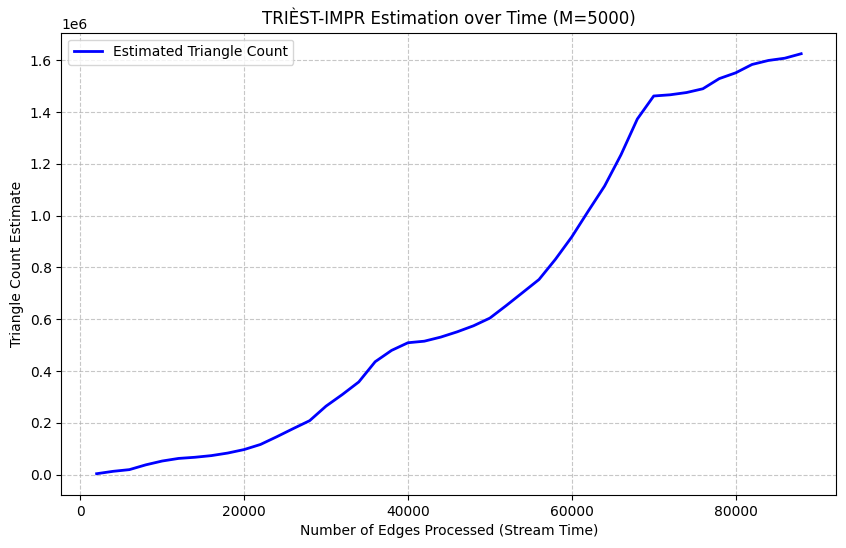

In [10]:
# --- Simple Visualization ---
plt.figure(figsize=(10, 6))
plt.plot(history_t, history_est, label='Estimated Triangle Count', color='blue', linewidth=2)
plt.title(f'TRIÈST-IMPR Estimation over Time (M={MEMORY_SIZE})')
plt.xlabel('Number of Edges Processed (Stream Time)')
plt.ylabel('Triangle Count Estimate')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# --- Release Spark Resources ---
# Run this line only when you are completely finished and no longer need Spark
# spark.stop()
# print("Spark Session stopped.")

--- Starting Parameter Sensitivity Test ---
Ground Truth: 1612010
------------------------------------------------------------
Memory (M)      | Estimate        | Error (%)       | Time (s)  
------------------------------------------------------------
1000            | 1765274         | 9.51            | 0.12      
2500            | 1621739         | 0.60            | 0.10      
5000            | 1526567         | 5.30            | 0.15      
7000            | 1620528         | 0.53            | 0.14      
10000           | 1624929         | 0.80            | 0.16      
13000           | 1604621         | 0.46            | 0.17      
16000           | 1617964         | 0.37            | 0.19      
20000           | 1602356         | 0.60            | 0.20      
------------------------------------------------------------


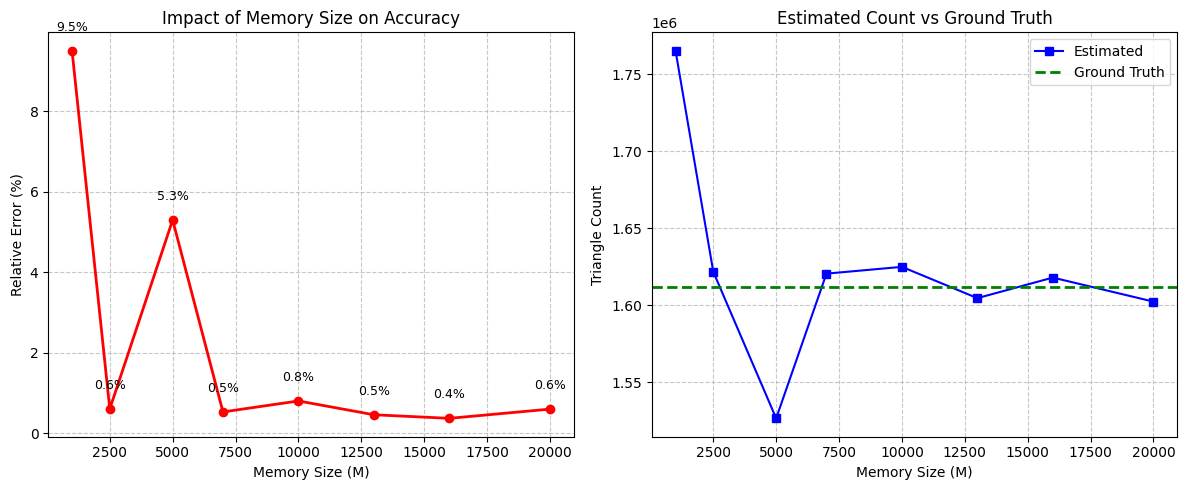

In [12]:
import matplotlib.pyplot as plt
import time

# Official Ground Truth
GROUND_TRUTH = 1612010 

# A set of memory size parameters we want to test
# Suggested to set a wide range to see the effect clearly
memory_candidates = [1000, 2500, 5000, 7000, 10000, 13000, 16000, 20000]

errors = []
estimates = []
times = []

print(f"--- Starting Parameter Sensitivity Test ---")
print(f"Ground Truth: {GROUND_TRUTH}")
print("-" * 60)
print(f"{'Memory (M)':<15} | {'Estimate':<15} | {'Error (%)':<15} | {'Time (s)':<10}")
print("-" * 60)

# Ensure RDD is cached to speed up multiple iterations
if not edges_rdd.is_cached:
    edges_rdd.cache()

for m in memory_candidates:
    # 1. Initialize algorithm
    algo = TriestImpr(memory_size=m)
    
    # 2. Run algorithm (re-fetch iterator)
    start_t = time.time()
    iterator = edges_rdd.toLocalIterator()
    
    for u, v in iterator:
        algo.update((u, v))
        
    end_t = time.time()
    
    # 3. Record results
    est = algo.get_count()
    # Calculate absolute relative error
    error_rate = abs(est - GROUND_TRUTH) / GROUND_TRUTH * 100
    
    estimates.append(est)
    errors.append(error_rate)
    times.append(end_t - start_t)
    
    print(f"{m:<15} | {est:<15} | {error_rate:<15.2f} | {end_t - start_t:<10.2f}")

print("-" * 60)

# --- Visualization: Memory Size vs Relative Error ---
plt.figure(figsize=(12, 5))

# Subplot 1: Error Curve
plt.subplot(1, 2, 1)
plt.plot(memory_candidates, errors, marker='o', color='red', linewidth=2)
plt.title('Impact of Memory Size on Accuracy')
plt.xlabel('Memory Size (M)')
plt.ylabel('Relative Error (%)')
plt.grid(True, linestyle='--', alpha=0.7)
# Label specific values
for x, y in zip(memory_candidates, errors):
    plt.text(x, y+0.5, f"{y:.1f}%", ha='center', fontsize=9)

# Subplot 2: Estimated Value vs Ground Truth
plt.subplot(1, 2, 2)
plt.plot(memory_candidates, estimates, marker='s', label='Estimated', color='blue')
plt.axhline(y=GROUND_TRUTH, color='green', linestyle='--', label='Ground Truth', linewidth=2)
plt.title('Estimated Count vs Ground Truth')
plt.xlabel('Memory Size (M)')
plt.ylabel('Triangle Count')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()